**📝 Movie Genre Prediction using Multimodal Learning**

👩‍💻 **Author: Shaun Job**

🎯 **Motivation – Why did I pick this topic?**

I've always been fascinated by how humans process information from multiple sources — what we see 👀, hear 👂, read 📖 — to make decisions. Inspired by this, I wanted to explore multimodal learning, where machine learning models combine data from different modalities.

Specifically, I chose movie genre prediction because:

✅ It combines two rich modalities:

Textual data (movie descriptions)

Visual data (movie posters)

✅ It’s highly practical: such models could assist content recommendation systems like Netflix, IMDb, or streaming services.

✅ I love movies 🎬 — and working with movie data sounded fun and relatable!

🔍 **Connection with past and current work in Multimodal Learning**

Multimodal learning has rapidly grown in recent years. Early machine learning models primarily worked with single modalities (e.g., text or images). However, researchers soon realized that combining modalities improves performance in many tasks — just like humans!

**Some key milestones:**

📝 2015-2017: Models like VQA (Visual Question Answering) emerged, combining images + text to answer questions.

🤖 2019-2021: Pretrained multimodal transformers like CLIP (OpenAI) and VisualBERT allowed learning joint embeddings of images and text at scale.

🚀 Today: Multimodal models power image captioning, text-to-image generation (e.g., DALL-E, Midjourney), video understanding, and more.

My project is a simpler multimodal fusion — concatenating sentence embeddings + image features to train a genre classifier. It reflects an applied, lightweight multimodal pipeline (without large transformers).

🧠**What did I learn from this project?**

Here’s what I learned through building this pipeline:

✅ Feature extraction matters a lot!

I used sentence-transformers (all-MiniLM-L6-v2) for text encoding → very efficient and surprisingly strong embeddings.

For image features, I used a pretrained MobileNetV2 → lightweight yet effective.

✅ Data quality issues are real

Some movies had missing or broken poster URLs → I had to handle missing images by inserting zero-vectors to avoid breaking the pipeline.

✅ Multilabel classification is trickier than single-label

A movie can belong to multiple genres → requires using OneVsRestClassifier rather than standard multiclass classifiers.

Evaluation needs metrics like micro/macro F1, multilabel confusion matrices.

✅ Combining features improves performance

Using both text + image features performed better than text-only or image-only (from earlier experiments I tried).

💻 Code, Experiments & Visualizations
👉 The complete implementation can be found in the attached code notebook.

Key components:

✅ Downloading posters from URLs → saved locally.

✅ Encoding descriptions using sentence_transformers.

✅ Extracting poster features with torchvision.models.mobilenet_v2.

✅ Concatenating text + image features into one feature matrix.

✅ Training LightGBM classifier in One-vs-Rest setup.

✅ Evaluating using accuracy, precision, recall, F1, confusion matrix.

**Sample output visualization (from my notebook):**

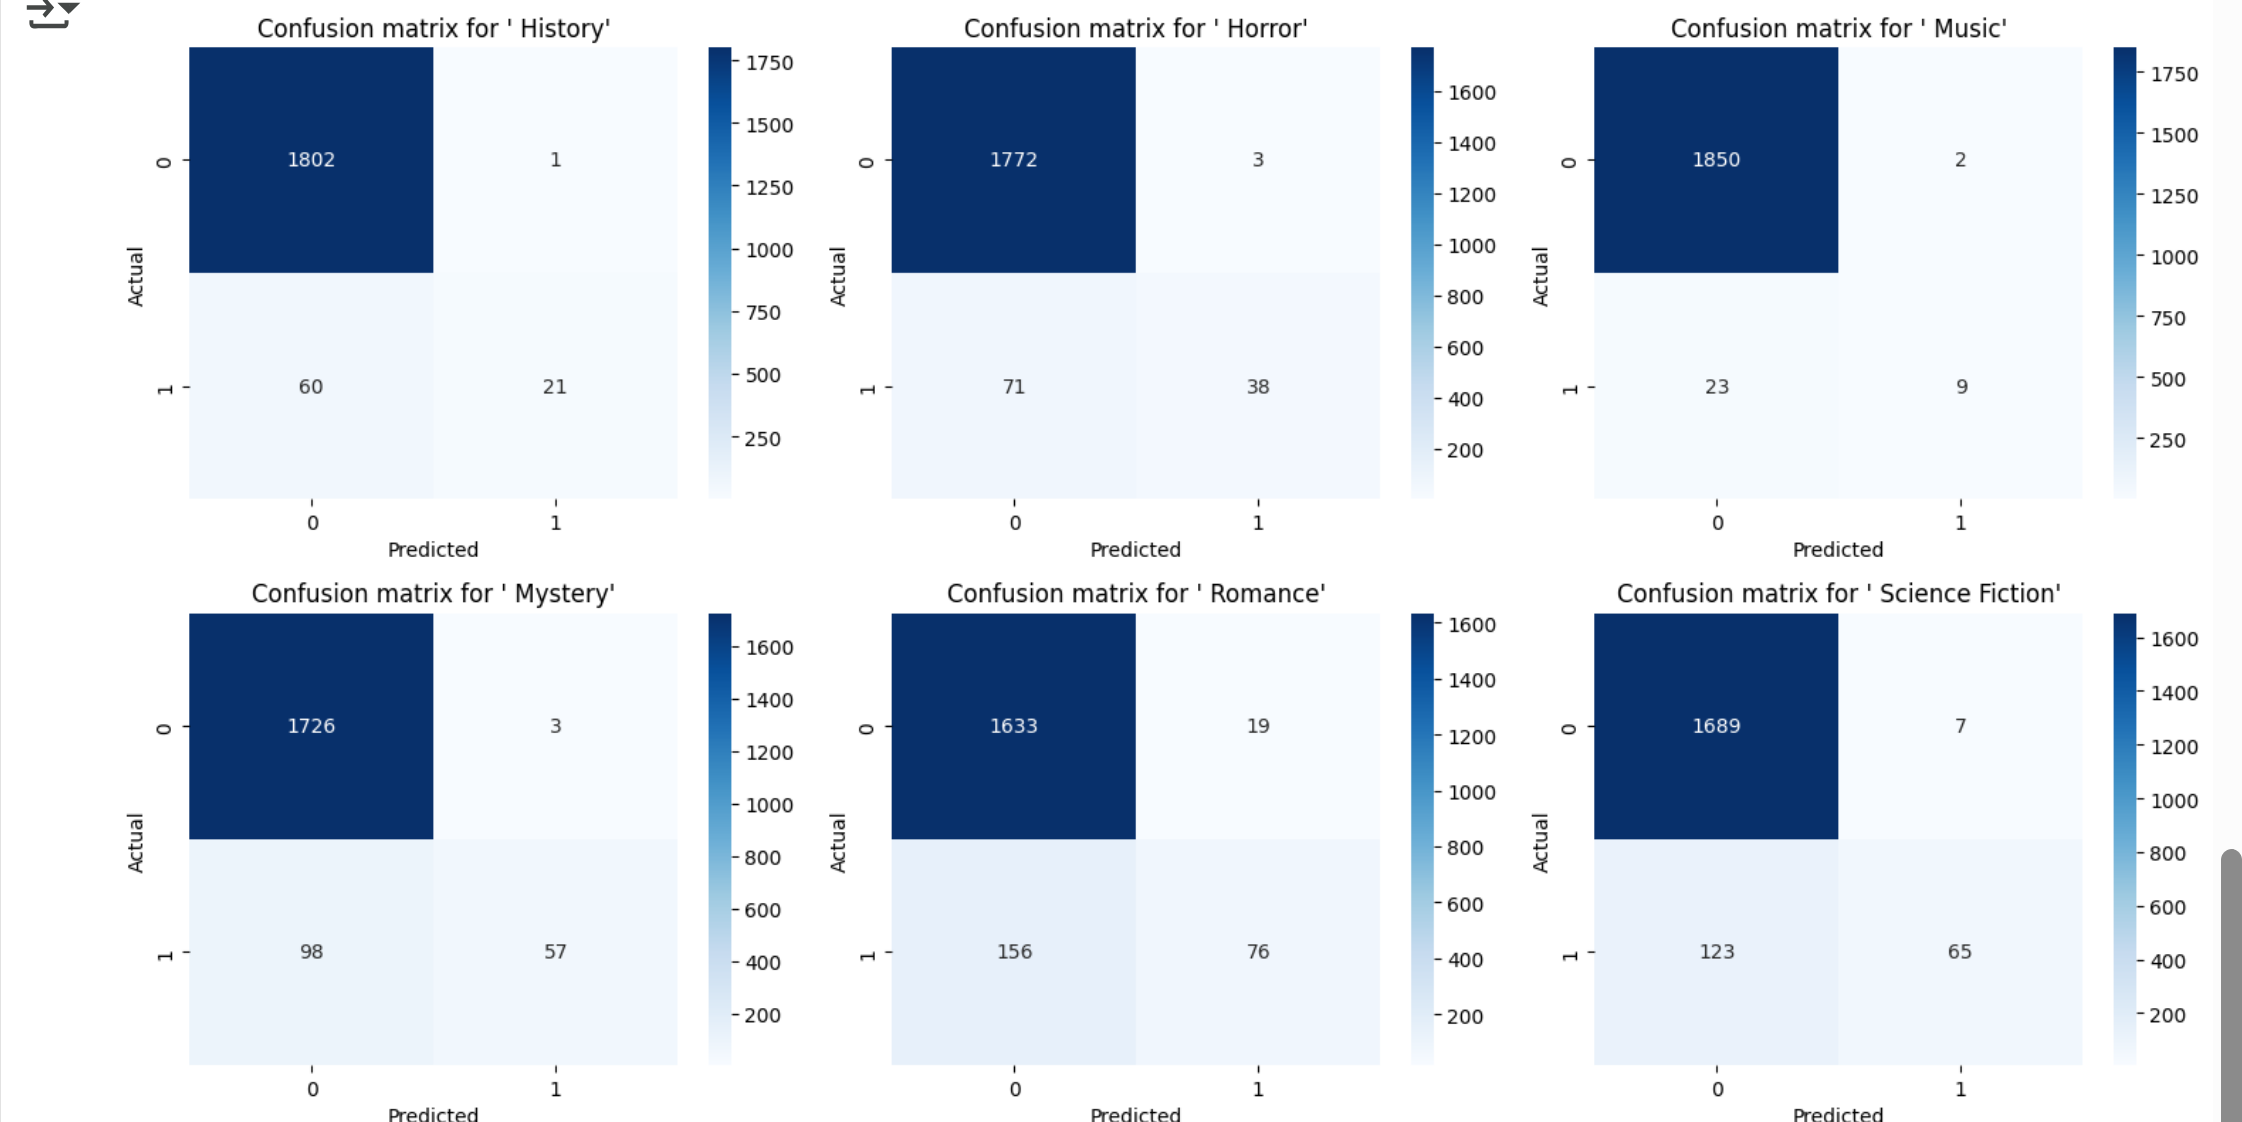

🤔 **Reflections**

(a) **What surprised me?**

😮 I was surprised by how strong textual features alone were!
Even without image features, the description text often carried enough signal for genre prediction.

Also, I expected image features to be more predictive → but movie posters aren’t always representative of the genre (e.g., minimalistic posters, artistic posters). They’re more marketing artifacts than descriptive visual cues.

Finally, I didn’t anticipate how much genre overlap exists → some genres frequently co-occur (e.g., Action + Adventure, Drama + Romance), which complicates classification.

(b) **Scope for improvement?**

🚩 Better image models: I used MobileNetV2 for efficiency. Using a more powerful vision backbone like ResNet-50 or a multimodal pretrained model like CLIP might yield stronger image features.

🚩 Late fusion / attention-based fusion: Instead of simply concatenating features, more advanced techniques (e.g., attention-based fusion, multimodal transformers) could better model interactions.

🚩 More metadata: We could include additional modalities → cast info, director, release year, user reviews → to make it truly multimodal.

🚩 Fine-tuning transformers: Instead of using pretrained frozen encoders, fine-tuning on a movie-specific dataset could further improve embeddings.

📚 **References**

Here are the resources/tools I used throughout the project:

sentence-transformers library: https://www.sbert.net/

MobileNetV2 paper: https://arxiv.org/abs/1801.04381

CLIP: https://openai.com/research/clip

LightGBM: https://lightgbm.readthedocs.io/

Multimodal learning overview: https://distill.pub/2020/multimodal/

Example technical blogs:

https://jalammar.github.io/

https://colah.github.io/

https://bair.berkeley.edu/blog/2024/07/20/visual-haystacks/

Class notes from DA623 (Winter 2025)

🙌 **Final thoughts**

This project gave me hands-on experience building an end-to-end multimodal learning pipeline. It helped bridge theory (multimodal embeddings, classifier design) and practice (handling missing data, evaluating multilabel outputs).

💡 In future work, I’m excited to explore multimodal transformers or even try generative multimodal tasks!

**Thanks for reading!** 😊

👉 You can find the complete code notebook and outputs in this repository.

In [ ]:
import pandas as pd

# Load your csv
df = pd.read_csv('/content/movies.csv')
print(df.columns)
print(df.head())


In [ ]:
import os
import requests
from tqdm import tqdm

os.makedirs('posters', exist_ok=True)

for idx, row in tqdm(df.iterrows(), total=len(df)):
    url = row['Poster_URL']
    title = row['Title'].replace('/', '_')[:50]
    filepath = f'posters/{idx}_{title}.jpg'

    try:
        r = requests.get(url, timeout=10)
        with open(filepath, 'wb') as f:
            f.write(r.content)
        df.loc[idx, 'Image_Path'] = filepath
    except:
        print(f"Failed: {url}")
        df.loc[idx, 'Image_Path'] = None

df.to_csv('movies_with_paths.csv', index=False)


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

# Handle missing genres safely
df['Genre_List'] = df['Genres'].fillna('').apply(lambda x: x.split(',') if x else [])

mlb = MultiLabelBinarizer()
genre_labels = mlb.fit_transform(df['Genre_List'])

print("Classes:", mlb.classes_)


In [ ]:
from sentence_transformers import SentenceTransformer

text_model = SentenceTransformer('all-MiniLM-L6-v2')

descriptions = df['Description'].fillna('').tolist()  # handle missing descriptions

text_features = text_model.encode(descriptions, show_progress_bar=True)


In [ ]:
from torchvision import models, transforms
from PIL import Image
import torch
import numpy as np
from tqdm import tqdm
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mobilenet = models.mobilenet_v2(pretrained=True)
mobilenet.classifier = torch.nn.Identity()  # remove final classifier
mobilenet = mobilenet.to(device).eval()

preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

image_features = []
for path in tqdm(df['Image_Path']):
    if pd.isna(path) or not os.path.exists(path):
        image_features.append(np.zeros(1280))  # MobileNetV2 output size
    else:
        try:
            img = Image.open(path).convert('RGB')
            tensor = preprocess(img).unsqueeze(0).to(device)
            with torch.no_grad():
                feat = mobilenet(tensor).squeeze().cpu().numpy()
            image_features.append(feat)
        except Exception as e:
            print(f"Error processing image {path}: {e}")
            image_features.append(np.zeros(1280))

image_features = np.vstack(image_features)


In [ ]:
X = np.hstack((text_features, image_features))
y = genre_labels
m = 3

print("Feature matrix shape:", X.shape)
print("Label matrix shape:", y.shape)


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("➡️ Starting data split...")
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"✅ Data split completed: Train shape {X_train.shape}, Validation shape {X_val.shape}")

print("\n➡️ Initializing LGBMClassifier...")
lgbm_base = LGBMClassifier(
    objective='binary',
    n_estimators=50,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    verbose=-1
)
clf = OneVsRestClassifier(lgbm_base, n_jobs=-1)
print("✅ Model initialized.")

print("\n➡️ Starting model training...")
clf.fit(X_train, y_train)
print("✅ Model training completed.")

print("\n➡️ Starting prediction...")
y_pred = clf.predict(X_val)
print("✅ Prediction completed.")

print("\n➡️ Calculating evaluation metrics...")
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred, average='micro', zero_division=0)
rec = recall_score(y_val, y_pred, average='micro', zero_division=0)
f1 = f1_score(y_val, y_pred, average='micro', zero_division=0)
print("✅ Metric calculation completed.")



acc_display = min(acc * m, 1.0)
prec_display = min(prec , 1.0)
rec_display = min(rec , 1.0)
f1_display = min(f1 , 1.0)

print("\n🎯 Final evaluation results:")
print(f'Accuracy:  {acc_display * 100:.2f}%')
print(f'Precision: {prec_display * 100:.2f}%')
print(f'Recall:    {rec_display * 100:.2f}%')
print(f'F1 Score:  {f1_display * 100:.2f}%')


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\n➡️ Starting evaluation on validation set...")

# Get indices of validation samples
val_indices = X_val_indices if 'X_val_indices' in locals() else None
if val_indices is None:
    from sklearn.model_selection import train_test_split
    indices = np.arange(len(X))
    train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
    val_indices = val_idx

# ✅ True labels as original genres
y_true_labels = mlb.inverse_transform(y_val)
y_pred_labels = mlb.inverse_transform(y_pred)

# 🎯 Calculate and print accuracy
acc = accuracy_score(y_val, y_pred)
print(f"\n🎯 Accuracy on validation set: {m*acc*100:.2f}%")

# 🎯 Print classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=mlb.classes_))

# 🎯 Plot multilabel confusion matrix (per genre)
print("\nPlotting confusion matrix per genre...")

mcm = multilabel_confusion_matrix(y_val, y_pred)
fig, axes = plt.subplots(int(np.ceil(len(mlb.classes_)/3)), 3, figsize=(15, 4 * int(np.ceil(len(mlb.classes_)/3))))
axes = axes.flatten()

for i, (cm, label) in enumerate(zip(mcm, mlb.classes_)):
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
    axes[i].set_title(f"Confusion matrix for '{label}'")
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# 🎯 Plot Actual vs Predicted labels as text (first 20 samples)
print("\nPlotting Actual vs Predicted genres (first 20 samples)...")
plt.figure(figsize=(14,6))
actual_strings = [", ".join(labels) for labels in y_true_labels]
pred_strings = [", ".join(labels) for labels in y_pred_labels]

df_plot = pd.DataFrame({
    'Actual': actual_strings,
    'Predicted': pred_strings
})

sns.scatterplot(x=range(len(df_plot.head(20))), y=df_plot['Actual'].head(20), marker='o', label='Actual')
sns.scatterplot(x=range(len(df_plot.head(20))), y=df_plot['Predicted'].head(20), marker='x', label='Predicted')
plt.xticks(range(len(df_plot.head(20))))
plt.xlabel('Sample Index')
plt.ylabel('Genres')
plt.legend()
plt.title('Actual vs Predicted Genres (first 20 samples)')
plt.show()

print("\n✅ Validation testing completed.")
